[View in Colaboratory](https://colab.research.google.com/github/3catz/deeplearning_timeseries/blob/master/Faes_Nonlinear_Autoregressive_Time_Series_Series_Forecasting_with_EEMD_and_Fully_Convolutional_Neural_Networks.ipynb)

#Faes EMD time series forecasting with Dilated Convolutional Neural Networks


This time series comes from [comp-engine.org](https://www.comp-engine.org/#!visualize/03d2f12f-387f-11e8-8680-0242ac120002), where there are many such time sets of data spanning decades. This is air quality, and has about 10k points. 
After splitting into training and testing, we run the Ensemble EMD (EEMD) process on the data. This is a method (Huang et al 1998(
of adaptive data analysis that makes little assumptions about the basis functions, and ends with a finite set of oscillating, orthogonal functions that show amplitude change on various time-frequency scales. 

Using ablation or dilated CNN kernels was an idea that came from [Borovykh et al](https://arxiv.org/pdf/1703.04691.pdf)
The idea of forecasting with EMDs as features--especially when you don't have any other features or can't hand-engineer something (or use second-order stats), is not original either.

[Yu et al](fhttps://www.researchgate.net/profile/Lean_Yu/publication/223376915_Forecasting_crude_oil_price_with_an_EMD-based_neural_network_ensemble_learning_paradigm/links/5a6751450f7e9b76ea8eecf2/Forecasting-crude-oil-price-with-an-EMD-based-neural-network-ensemble-learning-paradigm.pdf) have used EMD and ANNs for forecasting crude oil prices, comparing this with standard ARIMA.

[Du et al](http://cs229.stanford.edu/proj2017/final-reports/5244275.pdf) also mention the use of dilated convolutional networks for time series forecasting, which they pit against RNNs such as the LSTM and GRU.

This [Github User](https://github.com/kykosic/WaveNet-BTC/blob/master/Run%20Model.ipynb) has created a Tensorflow implementation of wavenet, for the purpose of intraday trading time series forecasting. Not sure how good the results are. 

By means of comparison, I then use autoML and the XGBoost Regression model, and I get a R2 score near what I achieved with the EEMD/IMF method--this without the use of EMD or IMFs at all, just with the last 20 lagged values of the time series. 


Using Ensemble Empirical Mode Decomposition and convolutional neural networks, I created an architecture for forecasting one step ahead based on a lookback of 20 time steps. The predictions for the out of sample set are not recursively defined, but are rather based on the ground-truth of the last 20 time steps. The R2 and explained variances scores are ok, at about 88.6%, though autoML using XGBoost regression got a R2 and explained variance of over 89%. 



In [1]:
!pip install EMD-signal
!pip install auto_ml
!pip install pyhht
from auto_ml import Predictor
#from auto_ml.utils import get_boston_dataset
from auto_ml.utils_models import load_ml_model

from PyEMD import EEMD 
#pip install PeakUtils
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score

import matplotlib.pyplot as plt
import os 
from scipy.integrate import odeint
#keras
from keras.models import *
from keras.layers import * 
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.engine.topology import Layer


Using TensorFlow backend.


# Utilities: series to supervised

In [0]:
def series_to_supervised(data, n_in, n_out, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Loading Data 

In [0]:
from google.colab import files    
files.upload()




Saving faes2.csv to faes2.csv


{'faes2.csv': b'-0.78664,-0.6193,-1.2258,0.12916,-0.21323,-0.55778,-1.0074,-0.26145,-1.2317,0.31627,0.2083,0.76871,0.66147,1.153,0.009089,0.60558,0.85498,0.65712,1.2033,-0.076888,0.35851,0.84075,0.56821,1.3119,-0.25734,-0.063752,-0.33103,-0.87719,-0.4653,-1.3781,0.36091,0.19276,0.75271,0.6888,1.0971,0.12977,0.95002,0.18504,1.0276,0.028477,0.60479,0.86567,0.63053,1.2496,-0.15587,0.14984,0.38037,0.97576,0.24789,1.188,-0.25735,-0.1257,-0.51835,-0.99008,-0.28264,-1.2633,0.34711,0.23435,0.84442,0.49724,1.3576,-0.33127,-0.16686,-0.67046,-0.83687,-0.73358,-1.0514,-0.2493,-1.2288,0.31834,0.21283,0.78057,0.63705,1.1975,-0.077854,0.35262,0.83362,0.5825,1.294,-0.23214,-0.018938,-0.17663,-0.54022,-1.0027,-0.26387,-1.2341,0.3184,0.21029,0.77454,0.64941,1.1755,-0.035927,0.47307,0.92145,0.42692,1.3917,-0.38802,-0.21142,-0.81207,-0.56334,-1.302,0.25001,0.053591,0.29551,0.81769,0.59208,1.2755,-0.2068,0.030789,-0.0050606,-0.00079844,-0.0050853,-0.016671,-0.055861,-0.18598,-0.58295,-0.96969,-0.36381,-1.3

In [0]:
import numpy as np  
data = np.fromfile("lorenz.dat", sep = "\n")

data.shape

In [0]:
import numpy as np
data = np.genfromtxt("faes2.csv", delimiter = ","); data = np.asarray(data); data.shape

(10000,)

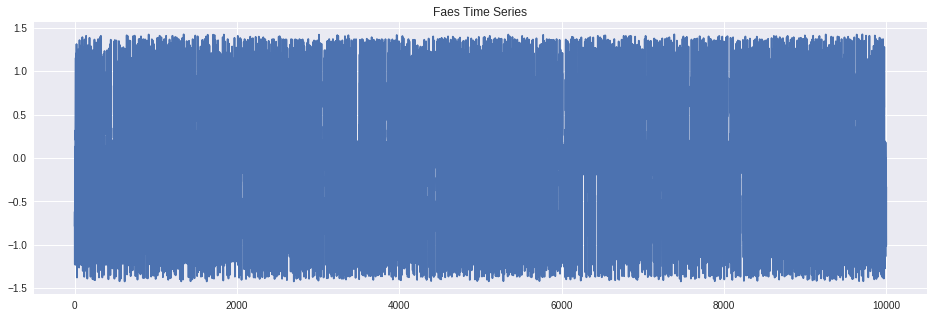

In [0]:
plt.figure(figsize=(16,5))
plt.plot(data)
plt.title("Faes Time Series")
plt.show()

In [0]:
#Scale the Data
scaler = MinMaxScaler(feature_range = (-1,1)) 
scaled_data = scaler.fit_transform(data.reshape(-1,1))
scaled_data.shape
scaled_data = np.squeeze(scaled_data)
scaled_data.shape

(10000,)

In [0]:
scaled_data = np.transpose(scaled_data)

In [0]:
# before you do the EMD, cut out the out of sample part so that the EMDs are not constructed with those future values and information contained within them

in_sample = scaled_data[:-1000]; out_sample = scaled_data[-1000:]
print(in_sample.shape)

(9000,)


In [0]:
in_sample = in_sample.reshape(-1,1)

#Empirical Mode Decomposition


In [0]:
eemd = EEMD()
eemd.extrema_detection = "simple"
t = np.linspace(0, in_sample.shape[0], in_sample.shape[0])
t = t.reshape(-1,1)
print(t.shape, in_sample.shape)
t = np.squeeze(t)
in_sample = np.squeeze(in_sample)

(9000, 1) (9000, 1)


In [0]:
imfs1 = eemd(in_sample, t)

print(imfs1.shape)

(16, 9000)


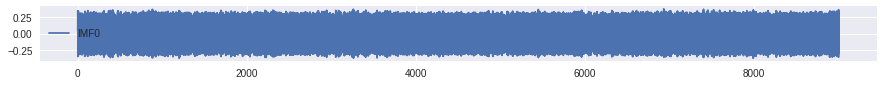

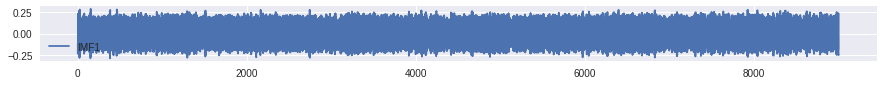

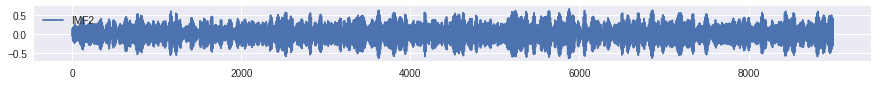

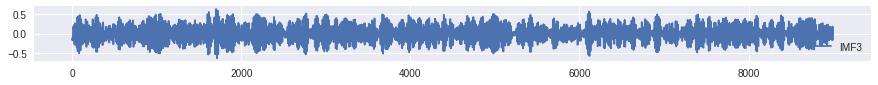

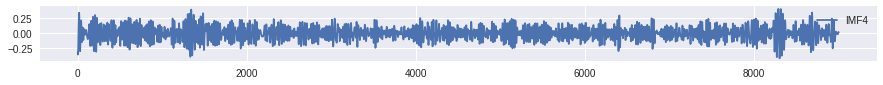

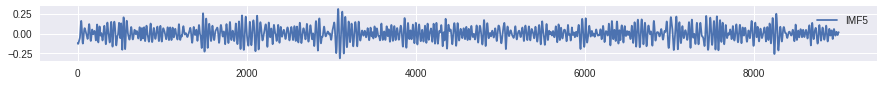

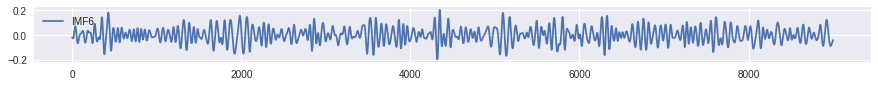

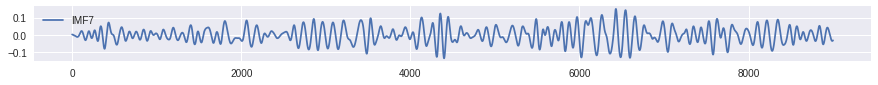

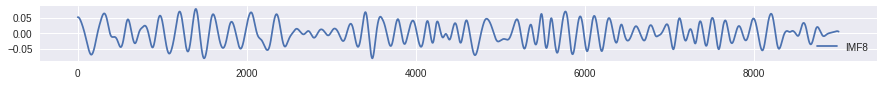

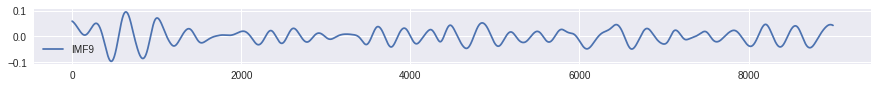

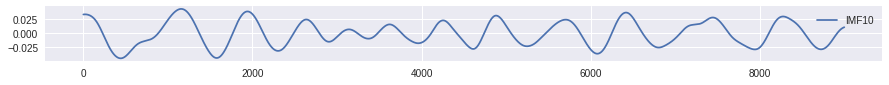

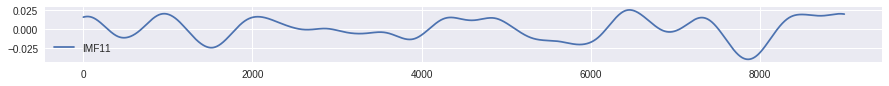

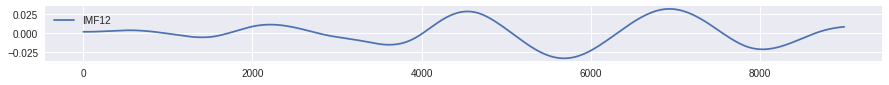

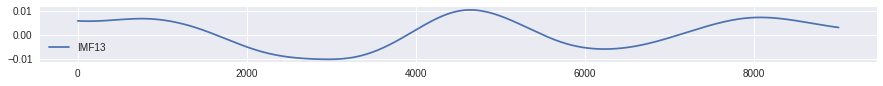

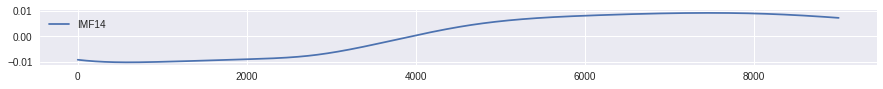

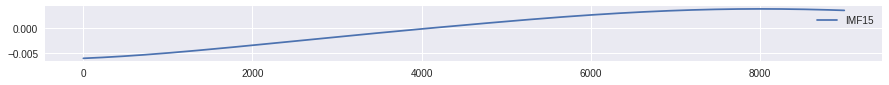

In [0]:
for i in range(len(imfs1)):
  fig, ax = plt.subplots(figsize=(15,1))
  fig = plt.plot(imfs1[i], label = "IMF{}".format(i))
  plt.legend()
  plt.show()

# Creating Datasets


*Raw Data, using lags = 20*

In [0]:
in_sample = in_sample.reshape(-1,1); print(in_sample.shape)

(9000, 1)


In [0]:
from pandas import DataFrame, concat
lookback = 20
data_f = series_to_supervised(in_sample, n_in = lookback, n_out = 1, dropnan = True)

In [0]:
print(data_f.shape)
data_f = np.asarray(data_f)
Xr = data_f[:,:-1]
print(Xr.shape)

(8980, 21)
(8980, 20)


# All IMFs

In [0]:
imfs1.shape
imfs1 = np.transpose(imfs1, (1,0)); 
print(imfs1.shape)
imf_df = series_to_supervised(imfs1, n_in = lookback, n_out = 1, dropnan = True)
imf_df = np.expand_dims(imf_df, axis = 1)
print(imf_df.shape)
imf_df = np.reshape(imf_df, (8980, 21, 16))

print(imf_df.shape)

(9000, 16)
(8980, 1, 336)
(8980, 21, 16)


In [0]:
#so you want imf_df[:,-1,:]
targets = imf_df[:,-1,:]
print(targets.shape)

(8980, 16)


In [0]:
#so reshape everything properly
input_data = np.reshape(Xr, (8980, 1, 20)); input_permuted = np.reshape(Xr,(8980, 20, 1))
targets = np.reshape(targets,(8980, 1, 16))
print(input_data.shape, targets.shape)

(8980, 1, 20) (8980, 1, 16)


In [0]:
#test Y values 

out_df = series_to_supervised(out_sample.reshape(-1,1), n_in = lookback, n_out = 1, dropnan = True)
print(out_df.shape); out_df = np.asarray(out_df)
testX = out_df[:,:-1]; testX = np.expand_dims(testX, axis = 1); print(testX.shape); 
testY = out_df[:,-1]; print(testY.shape)

(980, 21)
(980, 1, 20)
(980,)


# Partial autocorrelation 

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


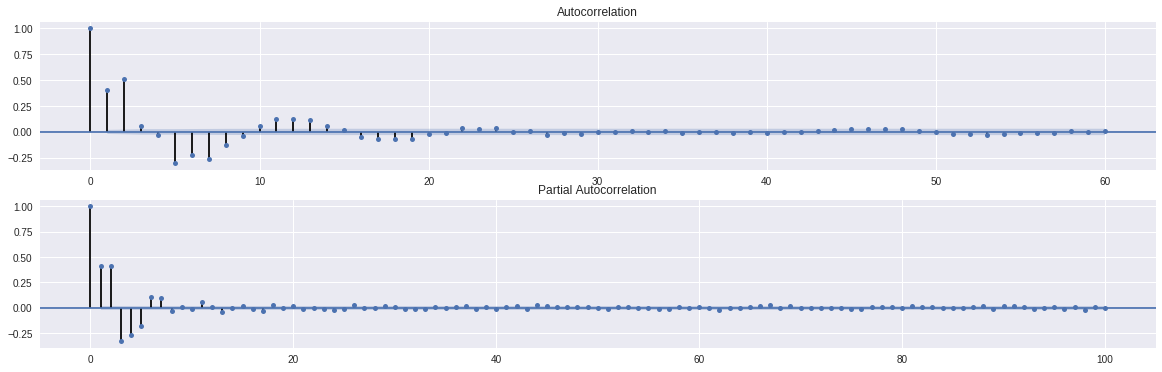

In [0]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, axes = plt.subplots(2, figsize=(20,6))
fig1 = plot_acf(scaled_data,lags = 60, ax = axes[0])
fig2 = plot_pacf(scaled_data, lags = 100, ax = axes[1])
plt.show()

# Network Architecture and Model fitting 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 1, 20)        0                                            
__________________________________________________________________________________________________
conv1d_61 (Conv1D)              (None, 1, 128)       2688        input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_62 (Conv1D)              (None, 1, 128)       2688        input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_63 (Conv1D)              (None, 1, 128)       2688        input_16[0][0]                   
__________________________________________________________________________________________________
concatenat

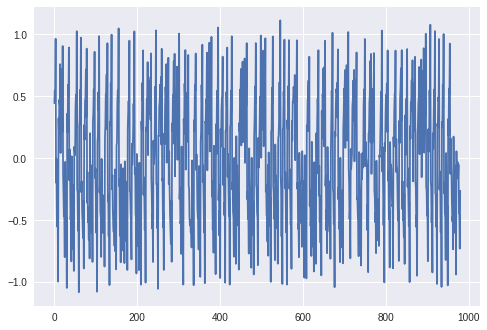

In [0]:
from keras.layers.advanced_activations import *
from keras.regularizers import l1, l2 
from sklearn.metrics import r2_score
import keras.backend as K
from keras.layers import LeakyReLU, Permute, Concatenate, Reshape, Input
from keras import optimizers
import numpy as np
np.random.seed(2018) 
pad = "causal"
activation  = "tanh"
inputs = Input(shape = (1, lookback))
enc = inputs 

x0 = Conv1D(128, 1, padding = pad, dilation_rate = 2, activation = "tanh")(enc)
x1 = Conv1D(128, 1, padding = pad, dilation_rate = 16, activation = "tanh")(enc)
x2 = Conv1D(128, 1, padding = pad, dilation_rate = 32, activation = "tanh")(enc)
x = concatenate([enc, x0, x1, x2])
x = Conv1D(256, 1,  padding = pad, activation = "tanh")(x)
predictions = Conv1D(16, 1, padding = pad, activation = "tanh")(x)
model = Model(inputs = inputs, outputs = predictions)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor = 0.9, patience = 3, min_lr = 1e-5, verbose = 1)
checkpointer = ModelCheckpoint(filepath = "timeseries_weights.hdf5", verbose = 1, save_best_only = True)
early = EarlyStopping(monitor = 'loss', min_delta = 1e-5, patience = 10, verbose = 1)

model.compile(optimizer = optimizers.Adadelta(lr = 1, clipnorm = .05), loss='mse', metrics = [])
model.summary()

history = model.fit(input_data, targets, 
          epochs = 100, 
          batch_size = 128, 
          verbose = 1, 
          #validation_data = (validX, validY),
          callbacks = [reduce_lr, early],
          shuffle = False)  

predictions = model.predict(testX, batch_size = 1)
print(predictions.shape)
summed = np.sum(predictions, axis = -1); print(summed.shape)
test_preds = summed[:,0]
plt.plot(test_preds); print(test_preds.shape) #does this match the testY.shape


Final R2 Score is: 0.9697822663871953
Final Explained Variance Score is: 0.9697824098690261.


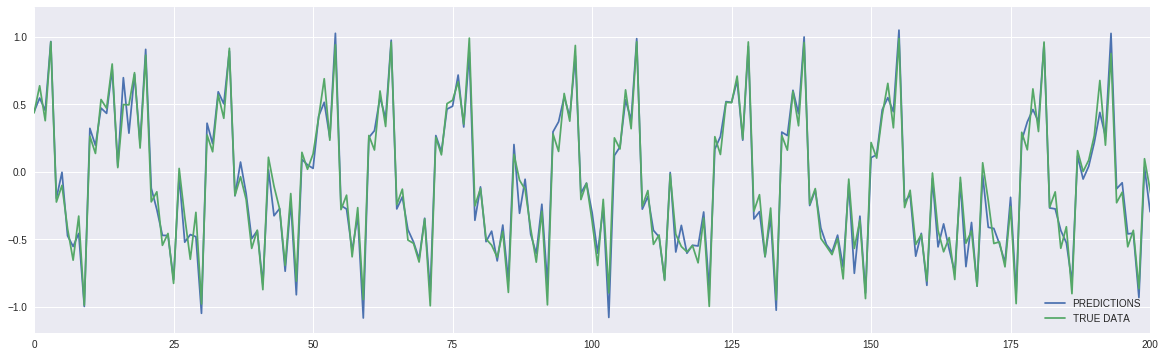

In [0]:
print("Final R2 Score is: {}".format(r2_score(testY, test_preds)))
from sklearn.metrics import explained_variance_score
print("Final Explained Variance Score is: {}.".format(explained_variance_score(testY, test_preds)))
fig = plt.figure(figsize = (20,6))
fig = plt.plot(test_preds, label = "PREDICTIONS")
fig = plt.plot(testY, label = "TRUE DATA")
plt.xlim([0,200])
plt.legend()
plt.show()

plt.clf()
plt.cla()
plt.close()

In [0]:
import pandas as pd
trainX = pd.DataFrame(data_f)
print(trainX)
trainX.columns = trainX.columns.astype(str)
column_descriptions = {"20":"output"}
ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions = column_descriptions)

ml_predictor.train(trainX, model_names=['XGBRegressor'])

            0         1         2         3         4         5         6   \
0    -0.552743 -0.435204 -0.861207  0.090511 -0.149982 -0.391993 -0.707804   
1    -0.435204 -0.861207  0.090511 -0.149982 -0.391993 -0.707804 -0.183852   
2    -0.861207  0.090511 -0.149982 -0.391993 -0.707804 -0.183852 -0.865351   
3     0.090511 -0.149982 -0.391993 -0.707804 -0.183852 -0.865351  0.221936   
4    -0.149982 -0.391993 -0.707804 -0.183852 -0.865351  0.221936  0.146098   
5    -0.391993 -0.707804 -0.183852 -0.865351  0.221936  0.146098  0.539727   
6    -0.707804 -0.183852 -0.865351  0.221936  0.146098  0.539727  0.464403   
7    -0.183852 -0.865351  0.221936  0.146098  0.539727  0.464403  0.809651   
8    -0.865351  0.221936  0.146098  0.539727  0.464403  0.809651  0.006173   
9     0.221936  0.146098  0.539727  0.464403  0.809651  0.006173  0.425146   
10    0.146098  0.539727  0.464403  0.809651  0.006173  0.425146  0.600323   
11    0.539727  0.464403  0.809651  0.006173  0.425146  0.600323

In [0]:
column_descriptions = {"20":"output"}
ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions = column_descriptions)

ml_predictor.train(trainX, model_names=['XGBRegressor'])

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}
Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to fit the pipeline for the model XGBRegressor to predict 20
Started at:
2018-09-28 22:03:22
Finished training the pipeline!
Total training time:
0:00:01


Here are the results from our XGBRegressor
predictin

In [0]:
out_df.shape
test_df = pd.DataFrame(out_df)
test_df.columns = test_df.columns.astype(str)


In [0]:
test_score = ml_predictor.score(test_df, test_df["20"])

None


***********************************************
Advanced scoring metrics for the trained regression model on this particular dataset:

Here is the overall RMSE for these predictions:
0.028934302890841812

Here is the average of the predictions:
-0.020072872237283355

Here is the average actual value on this validation set:
-0.019998946980632582

Here is the median prediction:
-0.03532266616821289

Here is the median actual value:
-0.03630329423333575

Here is the mean absolute error:
0.021285156547338792

Here is the median absolute error (robust to outliers):
0.014839364751433493

Here is the explained variance:
0.9968672908412547

Here is the R-squared value:
0.9968672703917616
Count of positive differences (prediction > actual):
498
Count of negative differences:
482
Average positive difference:
0.02087048861935168
Average negative difference:
-0.02171358938579851


***********************************************


